In [45]:
sys.path.append("/Users/martin/Sites/repos/csci6505-project-group")
print(sys.path)

['/Users/martin/Sites/repos/csci6505-project-group/notebooks', '/opt/local/Library/Frameworks/Python.framework/Versions/3.8/lib/python38.zip', '/opt/local/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8', '/opt/local/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/lib-dynload', '', '/Users/martin/Library/Python/3.8/lib/python/site-packages', '/opt/local/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages', '/Users/martin/Sites/repos/csci6505-project-group', '/Users/martin/Sites/repos/csci6505-project-group', '/Users/martin/Sites/repos/csci6505-project-group', '/Users/martin/Sites/repos/csci6505-project-group']


In [46]:
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from src.CNN.model import SimpleNet # local import

In [47]:
model = SimpleNet()

In [48]:
print(model)

SimpleNet(
  (unit1): Unit(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unit2): Unit(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unit3): Unit(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unit4): Unit(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (avgpool4): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (net): Sequential(
    (0): Unit(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [49]:
model.load_state_dict(torch.load("../models/base/model.model"))

<All keys matched successfully>

In [50]:
# we will save the conv layer weights in this list
model_weights =[]
# we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
# counter to keep count of the conv layers
counter = 0
# append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 4
conv_layers


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [52]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)])

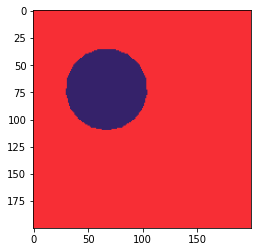

In [53]:
image = Image.open(str("../data/train/Circle_0abcfd9c-9caa-11ec-b61e-235a07e81dcd.png"))
plt.imshow(image)

In [54]:
image = transform(image)
print(f"Image shape before: {image.shape}")

image = image.unsqueeze(0)

print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 200, 200])
Image shape after: torch.Size([1, 3, 200, 200])


In [55]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

4
torch.Size([1, 32, 200, 200])
torch.Size([1, 64, 200, 200])
torch.Size([1, 128, 200, 200])
torch.Size([1, 128, 200, 200])


In [56]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(200, 200)
(200, 200)
(200, 200)
(200, 200)


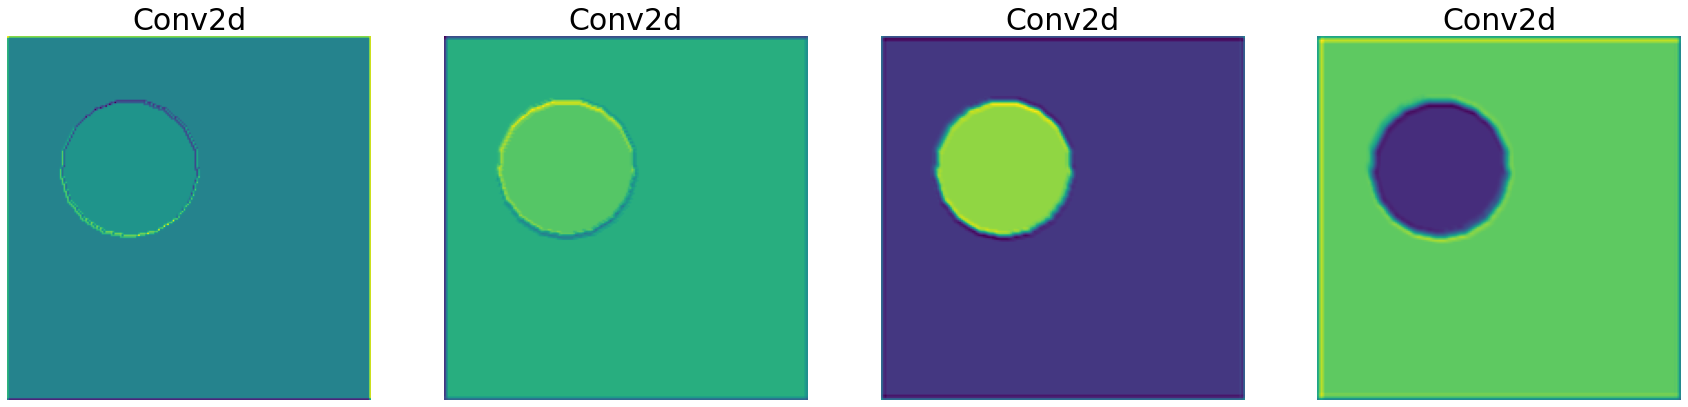

In [57]:
fig = plt.figure(figsize = (30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i + 1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')